In [1]:
import random
import bisect
import os
import math
import csv
import unittest
import pickle
import timeit
from tqdm import tqdm  # non-base python but just for nice progress bars!

input_file = "reads.csv"
output_file = "loci.csv"
points_file = "distinct_points.txt"
# pickleTree = "bob.pkl"
pickleTree = "segmentTree.pkl"


class SegmentTree:
    ## Heap based segment tree implemented as an array
    def __init__(self, points, segments, node=1, uncompressed=False, _n=0):
        n = len(points)
        if _n > 0:
            n = _n
        self.__total = 2 * n - 1
        self.__tree = [0] * int(self.__total + 2)  # actual tree data array of counts
        self.__N = int(self.__total / 2) - 1
        self.__points = points

        # Insertion of the intervals into the tree takes O(n * log(n)) time

        for i in tqdm(segments, desc="inserting segments:"):
            startpoint, endpoint = i
            if not uncompressed:
                startpoint, endpoint = (
                    bisect.bisect_right(self.__points, startpoint) + 1,
                    bisect.bisect_right(self.__points, endpoint) + 1,
                )
            self.insert(startpoint, endpoint)

    def insert(self, startpoint, endpoint):
        # Bottom up way to increment count for every node from the leaves
        # up to the elementary interval node (the node at which the
        # union of the two start and end leaf nodes occurs)
        # complexity O(log(n))
        l = startpoint + self.__N
        r = endpoint + self.__N
        # print("startpoint:", startpoint, "leaf node:", l)
        # print("startpoint:", startpoint, "leaf node:", r)
        while l <= r:
            if l % 2 == 1:
                self.__tree[l] += 1
            l = int(math.floor((l + 1) / 2))
            if r % 2 == 0:
                self.__tree[r] += 1
            r = int(math.floor((r - 1) / 2))

    def stab_query(self, point):
        # Bottom up way to return the sum of counts stored in
        # one traversal from leaf to root of the tree.
        # complexity O(log(n))
        count = 0

        # perform a binary search of the ordered array to find
        # the index of the leaf node corresponding to the given point
        node = int(bisect.bisect_right(self.__points, point) + self.__N) + 1

        while not self.complete(node):
            count += self.__tree[node]
            node = int(math.floor(node / 2))
            if node == 0:
                break
        return count

    def stab_query_uncompressed(self, point):  # gausa binser, gausah ada array bahkan
        # Bottom up way to return the sum of counts stored in
        # one traversal from leaf to root of the tree.
        # complexity O(log(n))
        count = 0
        node = point + 1 * self.__N
        while not self.complete(node):
            count += self.__tree[node]
            node = int(math.floor(node / 2))
            if node == 0:
                break
        return count

    def complete(self, node):
        # Boolean check if node is a complete binary subtree
        formula = 2 ** (
            math.floor(math.log(self.lowest_incomplete(node)))
            - math.floor(math.log(node))
        )
        z = math.floor(self.lowest_incomplete(node) / formula)
        if node == z:
            return True
        else:
            return False

    def lowest_incomplete(self, node):
        # Returns the lowest incomplete node
        t = math.log(self.__N & -self.__N)
        return int(math.floor(float(self.__N) / (2 ** (1 + t))))


def load_points(points_file):

    # Preprocessing: loads all distinct points from reads.csv,
    # then sorts all points, the sort takes O(n*log(n)) time using merge sort,
    # where n is the number of distinct start and end points.
    # Does this once and saves the list of points for use, to avoid re-sorting a 4~ish million item list again
    if not os.path.isfile(points_file):
        with open(input_file, "r") as csvfile:
            points = set()  # using set to reduce to distinct values
            reader = csv.DictReader(csvfile)
            for row in tqdm(reader, desc="building points list"):
                startpoint, length = int(row["start"]), int(row["length"])
                points.add(startpoint)
                points.add(startpoint + length)
        points = list(points)
        points.sort()
        with open(points_file, "w") as f:
            f.writelines("%s\n" % l for l in points)
    else:
        # otherwise load presorted distinct points list
        points = [int(line.rstrip("\n")) for line in open(points_file)]

    return points


def main():

    # check if we have already constructed and pickled the segment tree
    if not os.path.isfile(pickleTree):

        # performs preproccessing of points, or loads if already done
        points = load_points(points_file)

        # open reads.csv file and extract segments
        with open(input_file, "r") as csvfile:
            segments = []
            reader = csv.DictReader(csvfile)
            for row in reader:
                # use length to convert into start and end points all in one big array
                # for preprocessing for effienciently sorting and building segment tree,
                # and for storing segment values
                startpoint, length = int(row["start"]), int(row["length"])
                segments.append((startpoint, startpoint + length))

        # intiialize a balanced binary search tree with the number of leaves are
        # equal to distinct start and endpoints (in 'points' object), then populate it by inserting all the segments
        print(points, segments)
        segmentTree = SegmentTree(points, segments)
        print(segmentTree._SegmentTree__tree)

        # free up the segments and points objects are
        # now implicitly encoded within our segment tree
        segments = None
        points = None

        with open(pickleTree, "wb") as f:
            pickle.dump(segmentTree, f)
            print("Data has been pickled to file {}".format(f))

    else:
        # pickle load the already constructed segment tree
        with open(pickleTree, "rb") as f:
            print("Loading pickled segment tree, yum!")
            segmentTree = pickle.load(f)
            # print(segmentTree._SegmentTree__tree)

    # Open loci.csv to get positions for stab queries,
    # make stab queries and store the returned interval counts
    with open(output_file, "r") as csvfile:
        loci_list = [("position", "coverage")]
        reader = csv.DictReader(csvfile)
        for row in reader:
            position = int(row["position"])
            coverage = segmentTree.stab_query(position)
            loci_list.append((position, coverage))

    # Write interval counts to loci.csv
    with open(output_file, "w") as csvfile:
        writer = csv.writer(csvfile)
        writer.writerows(loci_list)
        print("wrote to loci.csv!")
    return loci_list


inserting segments:: 100%|██████████| 9/9 [00:00<00:00, 107240.73it/s]
.
----------------------------------------------------------------------
Ran 1 test in 0.002s

OK
inserting segments:: 100%|██████████| 9/9 [00:00<00:00, 109734.70it/s]
.
----------------------------------------------------------------------
Ran 1 test in 0.001s

OK
inserting segments:: 100%|██████████| 9/9 [00:00<00:00, 102023.61it/s]
.
----------------------------------------------------------------------
Ran 1 test in 0.002s

OK
inserting segments:: 100%|██████████| 9/9 [00:00<00:00, 112682.79it/s]
.
----------------------------------------------------------------------
Ran 1 test in 0.002s

OK
inserting segments:: 100%|██████████| 9/9 [00:00<00:00, 111353.20it/s]
.
----------------------------------------------------------------------
Ran 1 test in 0.002s

OK
inserting segments:: 100%|██████████| 9/9 [00:00<00:00, 109734.70it/s]
.
----------------------------------------------------------------------
Ran 1 test 

inserting segments:: 100%|██████████| 9/9 [00:00<00:00, 103421.19it/s]
.
----------------------------------------------------------------------
Ran 1 test in 0.002s

OK
inserting segments:: 100%|██████████| 9/9 [00:00<00:00, 87381.33it/s]
.
----------------------------------------------------------------------
Ran 1 test in 0.002s

OK
inserting segments:: 100%|██████████| 9/9 [00:00<00:00, 104567.14it/s]
.
----------------------------------------------------------------------
Ran 1 test in 0.002s

OK
inserting segments:: 100%|██████████| 9/9 [00:00<00:00, 105738.76it/s]
.
----------------------------------------------------------------------
Ran 1 test in 0.002s

OK
inserting segments:: 100%|██████████| 9/9 [00:00<00:00, 87584.07it/s]
.
----------------------------------------------------------------------
Ran 1 test in 0.002s

OK
inserting segments:: 100%|██████████| 9/9 [00:00<00:00, 108162.57it/s]
.
----------------------------------------------------------------------
Ran 1 test in

inserting segments:: 100%|██████████| 9/9 [00:00<00:00, 115439.56it/s]
.
----------------------------------------------------------------------
Ran 1 test in 0.002s

OK
inserting segments:: 100%|██████████| 9/9 [00:00<00:00, 103421.19it/s]
.

5.69 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)



----------------------------------------------------------------------
Ran 1 test in 0.002s

OK


In [60]:
MAX = 100000000
class TestCase(unittest.TestCase):
    def test_toy_set_uncompressed(self):
        segments = []
        segments.extend(
            [
                (3, 4),
                (3, 4),
                (3, 4),
                (3, 4),
                (3, 6),
                (10, 20),
                (6, 50),
                (3, 3),
                (MAX-1, MAX),
            ]
        )
        points = [3, 4, 6, 7, 8, 9, 10, 20, 50, 76, 89, MAX-1, MAX]
        # points = [i for i in range(1, max(points) + 1)] # ga perlu array lagi
        # points.sort() # gaperlu sort lagi

        segmentTree = SegmentTree(points, segments, 1, 1, max(points))
        self.assertEqual(
            2, segmentTree.stab_query_uncompressed(15), "output for 15 should be 2"
        )
        self.assertEqual(
            6, segmentTree.stab_query_uncompressed(3), "output for 3 should be: 6"
        )
        self.assertEqual(
            5, segmentTree.stab_query_uncompressed(4), "output for 4 should be: 5"
        )
        self.assertEqual(
            1, segmentTree.stab_query_uncompressed(7), "output for 7 should be: 1"
        )
        self.assertEqual(
            2, segmentTree.stab_query_uncompressed(6), "output for 6 should be: 2"
        )
        self.assertEqual(
            1,
            segmentTree.stab_query_uncompressed(MAX),
            "output for 10000 should be: 1",
        )

In [61]:
%%timeit -n100 -r1
unittest.main(argv=['first-arg-is-ignored'], exit=False)

inserting segments:: 100%|██████████| 9/9 [00:00<00:00, 111353.20it/s]
.
----------------------------------------------------------------------
Ran 1 test in 1.511s

OK
inserting segments:: 100%|██████████| 9/9 [00:00<00:00, 23997.92it/s]
.
----------------------------------------------------------------------
Ran 1 test in 1.245s

OK
inserting segments:: 100%|██████████| 9/9 [00:00<00:00, 112682.79it/s]
.
----------------------------------------------------------------------
Ran 1 test in 1.060s

OK
inserting segments:: 100%|██████████| 9/9 [00:00<00:00, 112347.43it/s]
.
----------------------------------------------------------------------
Ran 1 test in 1.104s

OK
inserting segments:: 100%|██████████| 9/9 [00:00<00:00, 17582.08it/s]
.
----------------------------------------------------------------------
Ran 1 test in 1.336s

OK
inserting segments:: 100%|██████████| 9/9 [00:00<00:00, 115439.56it/s]
.
----------------------------------------------------------------------
Ran 1 test in

inserting segments:: 100%|██████████| 9/9 [00:00<00:00, 116508.44it/s]
.
----------------------------------------------------------------------
Ran 1 test in 1.073s

OK
inserting segments:: 100%|██████████| 9/9 [00:00<00:00, 109734.70it/s]
.
----------------------------------------------------------------------
Ran 1 test in 1.075s

OK
inserting segments:: 100%|██████████| 9/9 [00:00<00:00, 115087.61it/s]
.
----------------------------------------------------------------------
Ran 1 test in 1.070s

OK
inserting segments:: 100%|██████████| 9/9 [00:00<00:00, 108473.38it/s]
.
----------------------------------------------------------------------
Ran 1 test in 1.097s

OK
inserting segments:: 100%|██████████| 9/9 [00:00<00:00, 112682.79it/s]
.
----------------------------------------------------------------------
Ran 1 test in 1.100s

OK
inserting segments:: 100%|██████████| 9/9 [00:00<00:00, 118334.60it/s]
.
----------------------------------------------------------------------
Ran 1 test 

inserting segments:: 100%|██████████| 9/9 [00:00<00:00, 106035.78it/s]
.
----------------------------------------------------------------------
Ran 1 test in 1.024s

OK
inserting segments:: 100%|██████████| 9/9 [00:00<00:00, 115087.61it/s]
.

1.1 s ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)



----------------------------------------------------------------------
Ran 1 test in 1.028s

OK


In [92]:
MAX = 10000000
class TestCase(unittest.TestCase):
    def test_toy_set(self):
        segments = []
        segments.extend(
            [
                (3, 4),
                (3, 4),
                (3, 4),
                (3, 4),
                (3, 6),
                (10, 20),
                (6, 50),
                (3, 3),
                (MAX-1, MAX),
            ]
        )
        points = [3, 4, 6, 7, 8, 9, 10, 20, 50, 76, 89, MAX-1, MAX]
        points.sort()

        segmentTree = SegmentTree(points, segments)
        self.assertEqual(2, segmentTree.stab_query(15), "output for 15 should be 2")
        self.assertEqual(6, segmentTree.stab_query(3), "output for 3 should be: 6")
        self.assertEqual(5, segmentTree.stab_query(4), "output for 4 should be: 5")
        self.assertEqual(1, segmentTree.stab_query(7), "output for 7 should be: 1")
        self.assertEqual(2, segmentTree.stab_query(6), "output for 6 should be: 2")
        self.assertEqual(
            1, segmentTree.stab_query(MAX), "output for 10000 should be: 1"
        )

In [93]:
%%timeit -n100 -r1
unittest.main(argv=['first-arg-is-ignored'], exit=False)

inserting segments:: 100%|██████████| 9/9 [00:00<00:00, 94608.36it/s]
.
----------------------------------------------------------------------
Ran 1 test in 0.002s

OK
inserting segments:: 100%|██████████| 9/9 [00:00<00:00, 99078.05it/s]
.
----------------------------------------------------------------------
Ran 1 test in 0.002s

OK
inserting segments:: 100%|██████████| 9/9 [00:00<00:00, 96791.63it/s]
.
----------------------------------------------------------------------
Ran 1 test in 0.002s

OK
inserting segments:: 100%|██████████| 9/9 [00:00<00:00, 95566.42it/s]
.
----------------------------------------------------------------------
Ran 1 test in 0.002s

OK
inserting segments:: 100%|██████████| 9/9 [00:00<00:00, 90092.45it/s]
.
----------------------------------------------------------------------
Ran 1 test in 0.002s

OK
inserting segments:: 100%|██████████| 9/9 [00:00<00:00, 94846.07it/s]
.
----------------------------------------------------------------------
Ran 1 test in 0.0

inserting segments:: 100%|██████████| 9/9 [00:00<00:00, 104567.14it/s]
.
----------------------------------------------------------------------
Ran 1 test in 0.002s

OK
inserting segments:: 100%|██████████| 9/9 [00:00<00:00, 97541.95it/s]
.
----------------------------------------------------------------------
Ran 1 test in 0.002s

OK
inserting segments:: 100%|██████████| 9/9 [00:00<00:00, 93902.33it/s]
.
----------------------------------------------------------------------
Ran 1 test in 0.002s

OK
inserting segments:: 100%|██████████| 9/9 [00:00<00:00, 114390.11it/s]
.
----------------------------------------------------------------------
Ran 1 test in 0.002s

OK
inserting segments:: 100%|██████████| 9/9 [00:00<00:00, 86579.67it/s]
.
----------------------------------------------------------------------
Ran 1 test in 0.002s

OK
inserting segments:: 100%|██████████| 9/9 [00:00<00:00, 82062.47it/s]
.
----------------------------------------------------------------------
Ran 1 test in 0

inserting segments:: 100%|██████████| 9/9 [00:00<00:00, 85019.68it/s]
.
----------------------------------------------------------------------
Ran 1 test in 0.002s

OK
inserting segments:: 100%|██████████| 9/9 [00:00<00:00, 116869.15it/s]
.


5.67 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)


----------------------------------------------------------------------
Ran 1 test in 0.002s

OK


Text(0.5, 1.0, 'Pertumbuhan waktu kueri stab pohon segmen terhadap meningkatnya nilai titik maksimum')

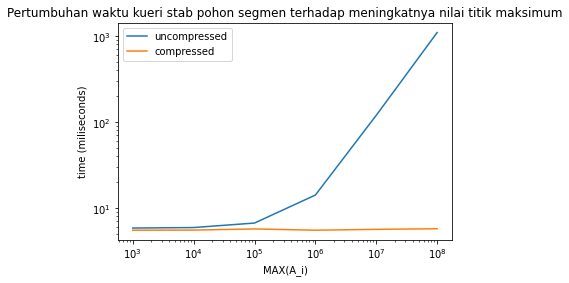

In [96]:
MAX = [int(x) for x in [1e3, 1e4, 1e5, 1e6, 1e7, 1e8]]
UNCOMPRESSED = [5.87, 5.95, 6.71, 14.2, 120, 1100] # in miliseconds
COMPRESSED = [5.54, 5.56, 5.73, 5.54, 5.67, 5.76]

# plot compressed vs uncompressed
import matplotlib.pyplot as plt
plt.plot(MAX, UNCOMPRESSED, label="uncompressed")
plt.plot(MAX, COMPRESSED, label="compressed")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("MAX(A_i)")
plt.ylabel("time (miliseconds)")
plt.legend()
plt.title("Pertumbuhan waktu kueri stab pohon segmen terhadap meningkatnya nilai titik maksimum")